In [39]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os

acropolis_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/acropolis/"
#acropolis_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"

In [40]:
df = pl.scan_parquet(os.path.join(acropolis_directory, "pivot_measurements.parquet"))
#df = pl.scan_parquet(os.path.join(acropolis_directory, "old_db_renamed_measurements.parquet"))

df = df.sort("creation_timestamp")
df.head(3).collect()

system_name,revision,creation_timestamp,receipt_timestamp,wxt532_direction_min,wxt532_speed_min,wxt532_last_update_time,wxt532_speed_avg,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_max,gmp343_compensated,bme280_humidity,sht45_temperature,bme280_pressure,sht45_humidity,gmp343_raw,bme280_temperature,gmp343_filtered,gmp343_temperature,enclosure_bme280_humidity,raspi_cpu_usage,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_memory_usage,enclosure_bme280_temperature,cal_gmp343_compensated,cal_gmp343_raw,cal_bme280_temperature,cal_gmp343_filtered,cal_sht45_temperature,cal_bme280_pressure,cal_sht45_humidity,cal_gmp343_temperature,cal_bme280_humidity,cal_bottle_id
str,i32,"datetime[ns, UTC]","datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""tum-esm-midcos…",23,2023-09-21 13:29:45.460 UTC,2023-09-21 13:29:47.860321 UTC,null,null,null,null,null,null,null,401.4,22.63,31.52,920.84,24.9,346.0,31.35,398.9,33.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""tum-esm-midcos…",23,2023-09-21 13:29:45.520 UTC,2023-09-21 13:29:47.924263 UTC,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,14.88,0.033,941.95,58.9,0.358,0.109,37.79,null,null,null,null,null,null,null,null,null,null
"""tum-esm-midcos…",23,2023-09-21 13:29:55.470 UTC,2023-09-21 13:29:56.827854 UTC,null,null,null,null,null,null,null,404.5,22.65,31.51,925.06,24.91,346.7,31.35,405.4,33.1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [41]:
df = df.with_columns([pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_800"),
                      pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_800")])

In [42]:
dfg = df.groupby([pl.col("creation_timestamp").dt.date(), pl.col("system_name")]).agg([pl.col("cal_400").drop_nulls(),
                                                                                    pl.col("cal_800").drop_nulls(),
                                                                                    pl.col("cal_bottle_id_400").drop_nulls().median(),
                                                                                    pl.col("cal_bottle_id_800").drop_nulls().median()])

In [43]:
def average_bottle(data):
    data = data.to_list()
    #2nd bottle
    if 50 < len(data) < 70:
        x = data[int(len(data)*0.3):int(len(data)*0.95)]
        return sum(x) / len(x)
    #1st bottle
    elif 70 < len(data) < 130:
        x = data[int(len(data)*0.5):int(len(data)*0.95)]
        return sum(x) / len(x)
    else:
        return 0.0

dfg = dfg.select([pl.col("creation_timestamp"),
            pl.col("system_name"),
            pl.col("cal_400").apply(lambda x: average_bottle(x)).alias("mean_cal_400"),
            pl.col("cal_800").apply(lambda x: average_bottle(x)).alias("mean_cal_800"),
            pl.col("cal_bottle_id_400"),
            pl.col("cal_bottle_id_800")
            ])

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-09-21,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-21,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-22,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-23,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-23,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-24,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-24,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-24,"""tum-esm-midcos…",0.0,0.0,null,null
2023-09-25,"""tum-esm-midcos…",0.0,0.0,null,null


In [44]:
# Calculate slope and intercept

In [47]:
dfg_test = dfg.sort(pl.col("creation_timestamp")).filter(pl.col("system_name") == "tum-esm-midcost-raspi-5").filter(pl.col("mean_cal_400") > 0.0 )

dfg_test.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-10-11,"""tum-esm-midcos…",397.5675,788.618519,22.0,29.0
2023-10-12,"""tum-esm-midcos…",381.666667,788.789744,22.0,29.0
2023-10-13,"""tum-esm-midcos…",398.046341,790.283019,22.0,29.0
2023-10-14,"""tum-esm-midcos…",396.424074,788.54359,22.0,29.0


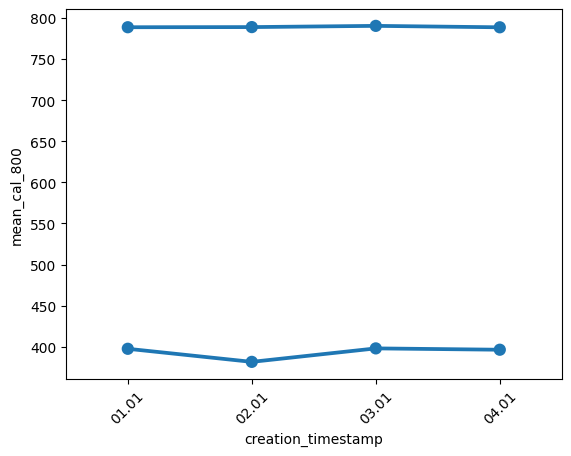

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="mean_cal_400")
sns.pointplot(data=dfg_test.collect().to_pandas(), x="creation_timestamp", y="mean_cal_800")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))